In this analysis, we are going to examine the dataset via a different angle: patterns of food cultures among counties in the U.S.. Variables different from previous analyese will be used, including those in these categories:  
 - Store availability  
 - Restaurant availability  
 - Local foods    
 
And other categories that are potentially more dependent on local government policies:  
 - Food prices and taxes    
 - Health and physical facilities  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1. Data import and cleaning

In [10]:
df = pd.read_csv('data_atlas/atlas.csv') # County data for all features
allfeatures = pd.read_csv('data_atlas/variables.csv',index_col='Category Code') # Feature names and details

# Filter out features not to be considered
# 1)Remove variables that measure '% change' between years
feature_filter1 = allfeatures.loc[(allfeatures['Units']!='% change')&(allfeatures['Units']!='Classification')]


# 2) For features that have two or more years, choose the most recent one only
# Split variable name in order to sort by years
feature_filter2 = pd.DataFrame(feature_filter1['Variable Name'].str.rsplit(', ',1).tolist(), columns=['Variable','Year']) 
feature = pd.concat([feature_filter1.reset_index(),feature_filter2],axis=1)

# # Sort by year and only keep the most recent year
feature = feature.sort_values(by='Year', ascending=False)
feature = feature.drop_duplicates(subset='Variable',keep='first')
feature = feature.set_index('Category Code')

# # Slice dataframe with the selected features plus county info
df = df.loc[:,['FIPS','State','County'] + feature['Variable Code'].tolist()] # Select data with updated features

In [11]:
print(feature.shape) # 147 features
print(df.shape)

(142, 9)
(3143, 145)


In [12]:
df = df.loc[:,['FIPS','State','County'] + feature['Variable Code'].tolist()] # Select data with updated features

In [13]:
df.head()

,FIPS,State,County,PCT_SNAP16,PCT_FMRKT_FRVEG16,FMRKT_SFMNP16,PCT_FMRKT_OTHERFOOD16,PCT_FMRKT_BAKED16,FMRKTPTH16,PCT_FMRKT_ANMLPROD16,...,PERPOV10,METRO13,PCH_CACFP_09_15,PCH_WIC_09_15,PCH_SFSP_09_15,PCH_SBP_09_15,PCH_NSLP_09_15,FOODINSEC_CHILD_03_11,CH_FOODINSEC_12_15,CH_VLFOODSEC_12_15
0,1001,AL,Autauga,16.976436,100.0,0.0,100.0,100.0,0.018045,0.0,...,0,1,0.139507,-0.271065,0.462219,0.723991,-1.380526,9.3,-0.3,0.5
1,1003,AL,Baldwin,16.976436,75.0,4.0,75.0,75.0,0.019179,100.0,...,0,1,0.139507,-0.271065,0.462219,0.723991,-1.380526,9.3,-0.3,0.5
2,1005,AL,Barbour,16.976436,50.0,2.0,50.0,50.0,0.154054,0.0,...,1,0,0.139507,-0.271065,0.462219,0.723991,-1.380526,9.3,-0.3,0.5
3,1007,AL,Bibb,16.976436,0.0,0.0,0.0,0.0,0.044164,0.0,...,0,1,0.139507,-0.271065,0.462219,0.723991,-1.380526,9.3,-0.3,0.5
4,1009,AL,Blount,16.976436,100.0,1.0,100.0,100.0,0.017330,100.0,...,0,1,0.139507,-0.271065,0.462219,0.723991,-1.380526,9.3,-0.3,0.5


### 2. Dealing with Missing values and outliers

#### Any comments on Iterative imputer for dealing with missing values? 

In [6]:
# Calculate state average values for each feature
state_avg = df.groupby('State',as_index=False).mean()

In [7]:
# Fill missing values using Iterative imputer
# which is a mmultivariate imputer that estimates each feature from all others
# Default estimator is BayesianRidge 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_mean = IterativeImputer(min_value=0,random_state=0) # All values should be non negative


In [8]:
transformed = imp_mean.fit_transform(df.drop(['FIPS','State','County'],axis=1))

/Users/Sabrina/anaconda3/lib/python3.6/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [9]:
df_imp = pd.DataFrame(transformed)
df_imp.columns = df.drop(['FIPS','State','County'],axis=1).columns
df_imp = pd.concat([df.loc[:,['FIPS','State','County']],df_imp],axis=1)

In [10]:
# Check examples of imputed missing values for DC
df_imp.loc[df_imp['State']=='DC',['FRESHVEG_ACRES12','GHVEG_FARMS12']]
# It sounds reasonable that DC has 0 fresh vegetable acres for fresh market 
# and around 10 greenhouse vegetable farms, since it is a metro aera.

,FRESHVEG_ACRES12,GHVEG_FARMS12
319,0.0,9.903522


In [11]:
df_imp.shape

(3143, 150)

In [12]:
# Winsorization of outliers 
from scipy.stats.mstats import winsorize

df_winsorized = df_imp.copy()
for column in df_winsorized.iloc[:,3:]:
    df_winsorized[column]=winsorize(df_winsorized[column],limits=[0.05,0.05])


### Q: impute missing values first or winsorize first?

In [13]:
local = df_winsorized.loc[:,['FIPS','State','County']+feature.loc['LOCAL','Variable Code'].tolist()]
restaurants = df_winsorized.loc[:,['FIPS','State','County']+feature.loc['RESTAURANTS','Variable Code'].tolist()]
stores = df_winsorized.loc[:,['FIPS','State','County']+feature.loc['STORES','Variable Code'].tolist()]

In [14]:
# Select features in the 'LOCAL' category. 46 selected
print(local.shape, restaurants.shape, stores.shape)

(3143, 49) (3143, 9) (3143, 15)


### 3. Clustering Analysis
#### Are there any patterns in local food environment among the counties?

#### 3.1. PCA

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler=StandardScaler()
local_scaled = scaler.fit_transform(local.drop(['FIPS','State','County'],axis=1))   # 'LOCAL' category
restaurants_scaled = scaler.fit_transform(restaurants.drop(['FIPS','State','County'],axis=1))   # 'LOCAL' category
stores_scaled = scaler.fit_transform(stores.drop(['FIPS','State','County'],axis=1))   # 'LOCAL' category


<BarContainer object of 46 artists>

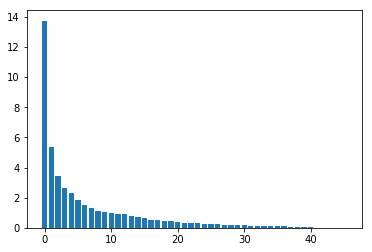

In [23]:
# LOCAL
pca = PCA()
pca_features = pca.fit_transform(local_scaled)
features = range(pca.n_components_)
plt.bar(features,pca.explained_variance_)


<BarContainer object of 6 artists>

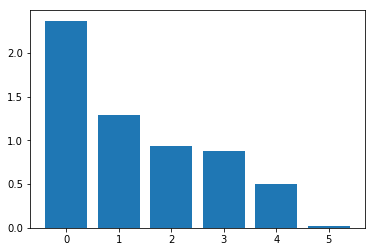

In [24]:
# Restaurants
pca = PCA()
pca_features = pca.fit_transform(restaurants_scaled)
features = range(pca.n_components_)
plt.bar(features,pca.explained_variance_)


<BarContainer object of 12 artists>

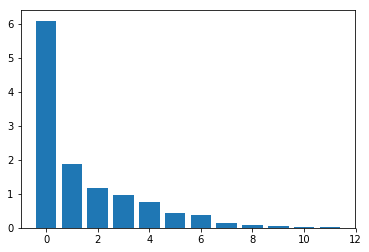

In [25]:
# Stores
pca = PCA()
pca_features = pca.fit_transform(stores_scaled)
features = range(pca.n_components_)
plt.bar(features,pca.explained_variance_)


In [26]:
local.head()

,FIPS,State,County,PCT_FMRKT_WICCASH16,PCT_FMRKT_FRVEG16,PCT_FMRKT_CREDIT16,PCT_FMRKT_SFMNP16,FMRKT_BAKED16,PCT_FMRKT_WIC16,FMRKT_SFMNP16,...,FRESHVEG_ACRESPTH12,ORCHARD_FARMS12,ORCHARD_ACRESPTH12,BERRY_FARMS12,BERRY_ACRESPTH12,DIRSALES12,GHVEG_SQFTPTH12,CSA12,AGRITRSM_OPS12,GHVEG_FARMS12
0,1001,AL,Autauga,0.0,100.0,0.0,0.0,1.0,0.0,0.0,...,64.527580,25.0,7.285908,5.0,0.090621,308.0,0.000000,3.0,10.0,0.0
1,1003,AL,Baldwin,0.0,75.0,50.0,100.0,3.0,0.0,4.0,...,19.447869,96.0,17.652682,39.0,0.488456,648.0,326.477447,7.0,16.0,4.0
2,1005,AL,Barbour,0.0,50.0,50.0,50.0,2.0,0.0,2.0,...,1.509628,58.0,29.419345,5.0,1.546449,13.0,0.000000,0.0,32.0,0.0
3,1007,AL,Bibb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.529989,4.0,0.574154,2.0,3.414746,20.0,267.153587,3.0,6.0,2.0
4,1009,AL,Blount,0.0,100.0,0.0,100.0,1.0,100.0,1.0,...,11.319579,28.0,3.046248,25.0,0.657713,495.0,0.000000,4.0,8.0,0.0


#### 3.2. K-means clustering

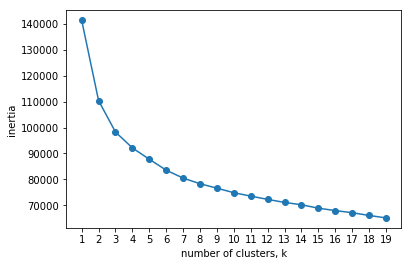

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
scaler=StandardScaler()
samples = local.drop(['FIPS','State','County'],axis=1) # 'LOCAL' category
scaled_samples = scaler.fit_transform(samples) 

# Create 'Elbow' plot
ks = range(1, 20) 
inertias = []
for k in ks:
     model = KMeans(n_clusters=k)
     model.fit(scaled_samples)
     inertias.append(model.inertia_)
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [18]:
# Use 3 clusters
model = KMeans(n_clusters=3,random_state=0)

model.fit(scaled_samples) 

labels = model.labels_

centroids = model.cluster_centers_ # For plotting

In [ ]:
# TBD


### Q: how to interpret PCA and K-means results ? How about use NMF , hierarchical clustering? 